In [3]:
# standard python utilities
import os
from os.path import exists, join, basename, dirname
import sys
import glob
import pandas as pd
import numpy as np
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import geopandas as gpd
# import gdal
import rasterio
# from rasterio.plot import show
import richdem
from rasterstats import zonal_stats

# mapping utilities
import contextily as ctx
# import osmnx as ox # open street map
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm



In [4]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
dis_dir = join(gwfm_dir, 'DIS_data')
uzf_dir = join(gwfm_dir,'UZF_data')

In [6]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


In [8]:
ag = gpd.read_file(join(uzf_dir, 'county_landuse','domain_ag_lu_2018.shp'))
# subset for relevant columns
ag = ag[['geom_id','name','irr_name','geometry']]
ag['group'] = 'ag'

native = gpd.read_file(join(uzf_dir, 'county_landuse','domain_native_lu_2018.shp'))
# subset for relevant columns
native = native[['geom_id','name','irr_name','geometry']]
native['group'] = 'native'

In [10]:
proj_dir = join(dirname(doc_dir), 'Box','SESYNC_Paper1')
# county parcel data data from 2023 with Sacramento, San Joaquin and El Dorado clipped to the domain
# parcels = gpd.read_file(proj_dir+'/Parcels - Model/Parcels - Model.shp')
# dwr agricultural land use
parcels = gpd.read_file(proj_dir+'/Parcels shapefile/parcels.shp')
# simplify parcel columns for producing output
keep_cols = ['UniqueID', 'layer','geometry']
parcels = parcels[keep_cols]
# change crs to utm zone 10
parcels = parcels.to_crs('epsg:32610')

<Axes: >

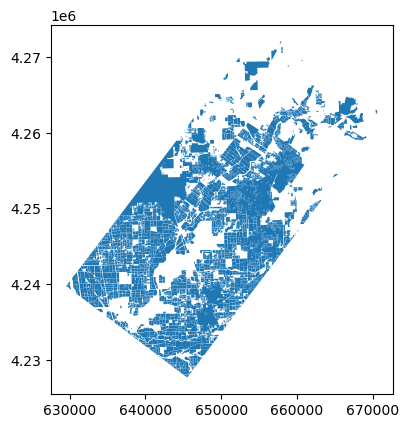

In [11]:
parcels.plot()

# Elevation zonal stats

In [ ]:
# burn river shapefile into the 10 meter dem and then read it out to find the cells where it is
# Full size dem of northern sac valley
raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"

dem = rasterio.open(raster_name)
# dem_10m = dem.read((1,))[0,:,:]

# affine = dem.affine # didn't work
affine = dem.meta['transform']

## Model Grid zonal stats

In [ ]:
# create list of quantiles to take in zonal stats
quants = []
for n in np.arange(0,110,10).astype(str):
    quants.append('percentile_'+n)
stats = ['mean', 'median', 'majority','std'] + quants
stats

In [ ]:
# takes several minutes
zs_grid = zonal_stats(grid_p, raster=raster_name, stats=stats)
# convert to dataframe
zs_df = pd.DataFrame(zs_grid)
# join zone stats of DEM to parcel data
zs_df = grid_p.join(zs_df)
# save to shapefile
zs_df.to_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')

## Parcel zonal stats
Can be done for county parcels (all) or ag parcels only (for the economic model).

In [ ]:
# runs quickly
# from rasterstats import gen_zonal_stats
# zs_gen = gen_zonal_stats(parcels, raster=raster_name, stats=['min', 'max', 'mean', 'median', 'majority','std'])

In [ ]:
# takes some time again
# still not sure where it svaes
# from rasterstats.utils import stats_to_csv
# csv = stats_to_csv(zs_gen)
# assert csv.split()[0] == ','.join(sorted(VALID_STATS))

In [ ]:

def elev_stats(raster_name, gdf, folder, name='parcel_elevation_m_statistics.shp'):
    # takes several minutes
    zs_parcels = zonal_stats(gdf, raster=raster_name, 
                             stats=['min', 'max', 'mean', 'median', 'majority','std'],
                            )
    # convert to dataframe
    zs_df = pd.DataFrame(zs_parcels)
    # join zone stats of DEM to parcel data
    zs_df = parcels.join(zs_df)
    # save to shapefile
    zs_df.to_file(join(proj_dir, folder, name))
                  
elev_stats(raster_name, parcels, 'parcel_zonalstats')
# elev_stats(raster_name, ag, 'ag_parcel_zonalstats')

# Slope, Aspect zonal stats

In [ ]:
# load DEM for slope/aspect analysis
rd_dem = richdem.LoadGDAL(raster_name)
# doesn't work without proper geotransform
# rd_dem = richdem.rdarray(dem_10m, no_data = dem.meta['nodata'], metadata = dem.meta)



In [ ]:

def attr_stats(rd_dem, gdf, attr, folder):
    # calculate slope/aspect
    rd_attr = richdem.TerrainAttribute(rd_dem, attr)

    # takes several minutes
    zs_parcels = zonal_stats(gdf, rd_attr, affine=affine, nodata=rd_attr.no_data,
                stats=['min', 'max', 'mean', 'median', 'majority', 'std'])
    # zs_parcels = zonal_stats(parcels, raster=raster_name, stats=['min', 'max', 'mean', 'median', 'majority','std'])
    # convert to dataframe
    zs_df = pd.DataFrame(zs_parcels)
    # join zone stats of DEM to parcel data
    zs_df = gdf.join(zs_df)
    # save to shapefile
    zs_df.to_file(join(proj_dir, folder, attr+'_statistics.shp'))
    return(zs_df)


In [ ]:
# attr = 'slope_percentage'
for attr in ['slope_percentage', 'slope_degrees', 'aspect']:
    slp = attr_stats(rd_dem, parcels, attr, 'parcel_zonalstats')

In [ ]:
# # attr = 'slope_percentage'
# for attr in ['slope_percentage', 'slope_degrees', 'aspect']:
#     slp = attr_stats(rd_dem, ag, attr, 'ag_parcel_zonalstats')

In [ ]:
slp.plot('mean')

In [ ]:
def gw_stats(raster_name, gdf, folder, name):
    # takes several minutes
    zs_parcels = zonal_stats(gdf, raster=raster_name, 
                             stats=['min', 'max', 'mean', 'std'],
                             # True:includes any cell that touches, False: center point
                             all_touched=True  
                            )
    # convert to dataframe
    zs_df = pd.DataFrame(zs_parcels)
    # join zone stats of DEM to parcel data
    zs_df = parcels.join(zs_df)
    # save to shapefile
    zs_df.to_file(join(proj_dir, folder, name))
    

In [ ]:
# calculate zonal stats for each GWE to parcel
gwe_files = glob.glob(join(gwfm_dir,'GHB_data', 'interpolated_data','*kriged.tif'))
gwe_files
for s in ['fall','spring']:
    for y in np.arange(2010, 2022):
#     for y in [2010]:
        gwe_file = join(gwfm_dir,'GHB_data', 'interpolated_data',s+str(y)+'_kriged.tif')
        gw_stats(gwe_file, parcels, 'parcel_zonalstats/gwe', name=s+str(y)+'_ft_amsl.shp')


In [ ]:
# concatenate the GWE information together
keep_cols = ['UniqueID', 'layer','mean']
gwe_all = pd.DataFrame()
for s in ['fall','spring']:
    for y in np.arange(2010, 2022):
#     for y in [2010]:
        gwe = gpd.read_file(join(proj_dir, 'parcel_zonalstats', 'gwe', s+str(y)+'_ft_amsl.shp'))
        gwe_all = pd.concat((gwe_all, gwe[keep_cols].assign(year=y, season=s)))

In [ ]:
dem_gdf = gpd.read_file(join(proj_dir, 'parcel_zonalstats', 'parcel_elevation_m_statistics.shp'))
dem_gdf = dem_gdf[keep_cols+['geometry']]

In [ ]:
# for the GWE rasters which are 100 m resolution some parcels don't fall under it so I need to add
# the parameter all_touched=True
# even with this a few fields on the edge of the domain do not have 'gwe' in certain years

In [ ]:
gwe_all = gwe_all.rename(columns={'mean':'gwe_ft_mean'})
dem_gdf = dem_gdf.rename(columns={'mean':'dem_mean'})
gwe_dem_all = dem_gdf.merge(gwe_all, on=['UniqueID','layer'])
# gwe_dem_all.head(20)
# fig,ax=plt.subplots()
# # grid_p.plot(ax=ax)
# gwe_dem_all[gwe_dem_all.gwe_mean.isna()].plot(ax=ax, color='red')


In [ ]:
# calculate dtw, convert GWE from ft to m
gwe_dem_all['dtw_m'] = gwe_dem_all.dem_mean - gwe_dem_all.gwe_ft_mean*0.3048
gwe_dem_all[(gwe_dem_all.year==2021)&(gwe_dem_all.season=='fall')].plot('dtw_m',legend=True)

In [ ]:
gwe_dem_all.to_file(join(proj_dir, 'parcel_zonalstats', 'gw_dtw_all.shp'))

# Soil data
Join gridded data to parcel data to calculate the soil parameters at the parcel scale for irrigated lands only.


Originally I used the ag parcels only from 2015/2018, but with the combined parcel map from Yusuke it makes sense to standardize and use that with nulls inserted when those fields aren't calculated or assume a standard native/fallow land use.

In [12]:
uzf_dir = gwfm_dir+'/UZF_data'
soil_path = join(uzf_dir,'clean_soil_data')


In [13]:
gpd_soil = gpd.read_file(join(soil_path, 'cleaned_spatial_soil.shp'))

In [ ]:
# grid_uzf = gpd.read_file(uzf_path+'/final_grid_uzf/griduzf.shp')

In [23]:
# # only keep numeric columns that can be averaged (won't need texture class or HydGroup)
# field_id = 'ag'
# soil_ag = gpd.overlay(gpd_soil, ag) #geom_id
# id_cols = ['geom_id','name','irr_name']

field_id = 'parcel'
soil_ag = gpd.overlay(gpd_soil, parcels) # UniqueID
# soil_ag = soil_ag.rename(columns={'UniqueID':'geom_id'})
id_cols = ['UniqueID']

In [42]:
# soil_ag.dissolve(id_cols, pd.Series.mode)

In [45]:
from scipy.stats import mode
# calculate average soil parameters
soil_ag_cln = soil_ag.set_index(id_cols).loc[:, soil_ag.dtypes!=object]
soil_ag_cln = soil_ag_cln.dissolve(id_cols, np.mean)

def diss_mode(x):
    m = pd.Series.mode(x)
    if len(m) == 1: 
        return m
    # else:
    #     return m.iloc[0]
# for objects use the mode - new error pops up 
soil_ag_mode = soil_ag.dissolve(id_cols, diss_mode)
# add string cols back (texture, hydgroup)
soil_ag_cln = soil_ag_cln.join( soil_ag_mode[['Texture','HydGroup']]).reset_index()

In [46]:
soil_ag_cln['area_m2'] = soil_ag_cln.geometry.area

In [47]:
soil_ag_cln.drop(columns='geometry').to_csv(join(soil_path, 'soil_for_'+field_id+'_fields.csv'))

In [48]:
# identify the grid cells that will be connected to each ag field
grid_soil = gpd.overlay(grid_p, soil_ag_cln)

# if there are multiple ag field in a cell then the recharge/pumping needs to be scaled by the ag field area within the cell
grid_soil['field_area'] = grid_soil.area

In [51]:
# save ag field - grid cell connection and area
grid_soil[id_cols+['row','column', 'field_area']].to_csv(join(soil_path, field_id+'_field_to_cell.csv'))

In [52]:
# there are some non-unique rows in the ag field dataset
soil_ag_cln.shape, ag.shape, ag.geom_id.unique().shape

((4040, 18), (2456, 5), (2419,))

## Runoff coefficients

In [54]:
# load data for slope
# zs_df = gpd.read_file(join(dis_dir, 'grid_zonal_stats','slope_percentage_statistics.shp'))
label = 'parcel_zonalstats'
if field_id =='ag':
    label=field_id+'_parcel_zonalstats'
zs_df = gpd.read_file(join(proj_dir, label,'slope_percentage_statistics.shp'))


In [55]:
soil_ag = soil_ag.assign(lu='Cultivated land')

In [56]:
# overlay crops geometry so cell area can be taken into account
C_gpd = pd.merge(soil_ag, zs_df[id_cols+['mean']])

In [57]:
# load curve number data and clean up
CN = pd.read_excel(join(gwfm_dir,'UZF_data','curve_numbers.xlsx'), comment='#')
CN = CN.rename(columns={'Cover type':'lu', 'Impervious':'impervious', 'Hydrologic Condition':'HydCond'})

CN_long = CN.melt(id_vars = ['lu','impervious','HydCond'], var_name='HydGroup', value_name='CN')
# columns for joining
CN_long = CN_long[['HydGroup','lu','impervious', 'HydCond', 'CN']]

In [58]:
# join spatial data to ID data for Curve Numbers
CN_out = C_gpd.join(CN_long.set_index(['HydGroup','lu']), on=['HydGroup','lu'], how='inner')

# for pasture there is an option of fair or poor hydrologic condition
# poor condition should be associated with slopes greater than 3%, less than 50% cover in hills
CN_pasture = CN_out[CN_out.lu=='Pasture']
hills_pasture = CN_pasture[(CN_pasture['mean']>=3)&(CN_pasture.HydCond=='Poor')]
flat_pasture = CN_pasture[(CN_pasture['mean']<3)&(CN_pasture.HydCond=='Fair')]
CN_pasture = pd.concat((hills_pasture, flat_pasture))
# add pasture back to out file
CN_out = CN_out[CN_out.lu!='Pasture']
CN_out = pd.concat((CN_out, CN_pasture))

In [59]:
CN_out[id_cols+['CN']].to_csv(join(soil_path, field_id+'_field_CN.csv'))